In [1]:
from models import MVCNN
from tools import ImgDataset
import torch
import numpy as np
import csv

In [2]:
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
model = MVCNN.SVCNN('svcnn')
weights = torch.load('model-00030.pth', map_location=device)
model.load_state_dict(weights)
model.to(device)
model.eval()

SVCNN(
  (net_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  

In [4]:
test_dataset = ImgDataset.MultiviewImgDataset(
    root_dir='ModelNet40-12View/*/test',
    scale_aug=False,
    rot_aug=False,
    test_mode=True,
    num_models=0,
    num_views=12,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# View Importance Calculation with Taylor Expansion

In multi-view CNN architectures, not all views contribute equally to the final prediction. Some views may capture more discriminative features than others. We'll calculate the importance of each view using a first-order Taylor expansion approach.

In [5]:
# Extract CNN feature extractor from the model
svcnn = model.net_1
num_views = 12  # Number of views per model

# Initialize tensor to store view importance values
view_importance = torch.zeros(num_views).to(device)

In [6]:
def calculate_view_importance(data, target):
    """
    Calculate the importance of each view using first-order Taylor expansion
    
    Arguments:
        data: Input tensor of shape [batch_size, num_views, channels, height, width]
        target: Ground truth labels
        
    Returns:
        view_importance: Tensor of shape [num_views] containing importance score for each view
    """
    batch_size = data.shape[0]
    num_views = data.shape[1]
    importance_scores = torch.zeros(num_views).to(device)
    
    # Use a smaller batch size if needed to avoid memory issues
    sub_batch_size = min(10, batch_size)
    
    for batch_idx in range(0, batch_size, sub_batch_size):
        end_idx = min(batch_idx + sub_batch_size, batch_size)
        current_batch_size = end_idx - batch_idx
        
        # Get data and targets for current sub-batch
        sub_data = data[batch_idx:end_idx]
        sub_targets = target[batch_idx:end_idx]
        
        # Process each view separately
        view_features = []
        for v in range(num_views):
            # Ensure we track gradients
            view_data = sub_data[:, v].clone().requires_grad_(True)
            
            # Forward pass through feature extractor
            features = svcnn(view_data)
            features = features.view(current_batch_size, -1)  # Flatten
            view_features.append(features)
        
        # Process each sample in the sub-batch
        for i in range(current_batch_size):
            # Extract features for this sample across all views
            sample_features = [feat[i:i+1] for feat in view_features]  # Keep batch dimension
            
            # Perform max pooling across views (MVCNN approach)
            pooled_features, indices = torch.max(torch.stack(sample_features, dim=1), dim=1)
            
            # Pass through classifier
            classifier = model.net_2
            logits = classifier(pooled_features)
            
            # Set target score as the one to maximize
            sample_target = sub_targets[i].item()
            target_score = logits[0, sample_target]  # Score for the correct class
            
            # Compute gradient of target score w.r.t features
            target_score.backward(retain_graph=(i < current_batch_size-1))
            
            # Calculate importance for each view using Taylor approximation
            for v in range(num_views):
                if view_data.grad is not None:
                    # Taylor importance: |gradient * feature|
                    grad = view_data.grad[i].abs()  # Gradient magnitude
                    feature = sub_data[i, v].abs()  # Feature magnitude
                    importance = (grad * feature).sum().item()
                    importance_scores[v] += importance
            
            # Clear gradients for next iteration
            if view_data.grad is not None:
                view_data.grad.zero_()
    
    # Normalize importance scores
    importance_sum = importance_scores.sum()
    if importance_sum > 0:
        importance_scores = importance_scores / importance_sum
    
    return importance_scores

In [7]:
# Alternative implementation with hook-based approach
def calculate_view_importance_hooks(data, target):
    """
    Calculate the importance of each view using first-order Taylor expansion with hooks
    
    This implementation uses PyTorch hooks to capture gradients directly
    """
    batch_size = min(5, data.shape[0])  # Process a small batch for memory efficiency
    num_views = data.shape[1]

    # Store importance scores
    importance_scores = torch.zeros(num_views).to(device)

    # Helper functions to store activations and gradients
    activations = {}
    gradients = {}

    def save_activation(name):
        def hook(module, input, output):
            activations[name] = output
        return hook

    def save_gradient(name):
        def hook(module, grad_input, grad_output):
            gradients[name] = grad_output[0]
        return hook

    # Register hooks on the model
    hooks = []
    for i, module in enumerate(model.net_1):
        if isinstance(module, torch.nn.Conv2d) and i in [0, 3, 6, 8, 11, 13, 16, 18]:
            hooks.append(module.register_forward_hook(save_activation(f'conv{i}')))
            hooks.append(module.register_backward_hook(save_gradient(f'conv{i}')))

    # Process each sample to calculate view importance
    for i in range(batch_size):
        for v in range(num_views):
            # Process a single view
            view_data = data[i:i+1, v].to(device)

            # Forward pass
            features = svcnn(view_data)
            features = features.view(1, -1)  # Flatten

            # Pass through classifier
            logits = model.net_2(features)

            # Target score
            sample_target = target[i].item()
            target_score = logits[0, sample_target]

            # Backward pass
            model.zero_grad()
            target_score.backward()

            # Calculate importance using Taylor approximation
            for key in activations:
                if key in gradients:
                    # Taylor importance: |gradient * activation|
                    act = activations[key]
                    grad = gradients[key]
                    importance = torch.sum(torch.abs(act * grad)).item()
                    importance_scores[v] += importance / len(activations)

    # Clean up hooks
    for hook in hooks:
        hook.remove()

    # Normalize importance scores
    if torch.sum(importance_scores) > 0:
        importance_scores = importance_scores / torch.sum(importance_scores)

    return importance_scores

In [8]:
# Simple approach for view importance
def simple_view_importance(data, target):
    """A simpler approach that uses feature magnitudes directly"""
    num_samples = min(20, data.shape[0])
    num_views = data.shape[1]
    importance_scores = torch.zeros(num_views).to(device)
    
    # Model components
    feature_extractor = model.net_1
    classifier = model.net_2
    
    # Get feature contributions
    for i in range(num_samples):
        # Get sample data and target
        sample_data = data[i:i+1]
        sample_target = target[i:i+1]
        
        # Extract features for each view
        view_features = []
        for v in range(num_views):
            view_data = sample_data[:, v]
            with torch.no_grad():
                features = feature_extractor(view_data)
                features = features.view(1, -1)
                view_features.append(features)
                
        # For each view, calculate importance
        for v in range(num_views):
            # Create a list of all views but with this view replaced with zeros
            mask_features = view_features.copy()
            mask_features[v] = torch.zeros_like(mask_features[v])
            
            # Max pooling across views
            with torch.no_grad():
                pooled, _ = torch.max(torch.cat(mask_features, dim=0), dim=0, keepdim=True)
                masked_output = classifier(pooled)
                
                # Calculate full output with all views
                full_pooled, _ = torch.max(torch.cat(view_features, dim=0), dim=0, keepdim=True)
                full_output = classifier(full_pooled)
                
                # Importance is how much output changes when view is masked
                target_idx = sample_target.item()
                importance = (full_output[0, target_idx] - masked_output[0, target_idx]).abs()
                importance_scores[v] += importance.item()
    
    # Normalize
    if importance_scores.sum() > 0:
        importance_scores = importance_scores / importance_scores.sum()
        
    return importance_scores

In [9]:
view_importance = torch.zeros(num_views).to(device)

print("Calculating view importance...")
for i, (target, data, paths) in enumerate(test_loader):
    print(f"Processing batch {i+1}/{len(test_loader)}")
    data = data.to(device)
    target = target.to(device)
    
    # Calculate importance for this batch
    batch_importance = calculate_view_importance(data, target)
    view_importance += batch_importance

# Normalize the accumulated importance scores
if view_importance.sum() > 0:
    view_importance = view_importance / view_importance.sum()

# Display the results
print("\nView Importance Scores:")
for i, score in enumerate(view_importance):
    print(f"View {i}: {score.item()}")

Calculating view importance...
Processing batch 1/233
Processing batch 2/233
Processing batch 3/233
Processing batch 4/233
Processing batch 5/233
Processing batch 6/233
Processing batch 7/233
Processing batch 8/233
Processing batch 9/233
Processing batch 10/233
Processing batch 11/233
Processing batch 12/233
Processing batch 13/233
Processing batch 14/233
Processing batch 15/233
Processing batch 16/233
Processing batch 17/233
Processing batch 18/233
Processing batch 19/233
Processing batch 20/233
Processing batch 21/233
Processing batch 22/233
Processing batch 23/233
Processing batch 24/233
Processing batch 25/233
Processing batch 26/233
Processing batch 27/233
Processing batch 28/233
Processing batch 29/233
Processing batch 30/233
Processing batch 31/233
Processing batch 32/233
Processing batch 33/233
Processing batch 34/233
Processing batch 35/233
Processing batch 36/233
Processing batch 37/233
Processing batch 38/233
Processing batch 39/233
Processing batch 40/233
Processing batch 4

In [10]:
# Sort views by importance
sorted_paths = torch.argsort(view_importance, descending=True)
print("Views sorted by importance (most important first):")
for i, idx in enumerate(sorted_paths):
    print(f"Rank {i+1}: View {idx.item()} - Score {view_importance[idx].item():.4f}")

Views sorted by importance (most important first):
Rank 1: View 0 - Score 0.1009
Rank 2: View 1 - Score 0.0955
Rank 3: View 3 - Score 0.0905
Rank 4: View 4 - Score 0.0889
Rank 5: View 8 - Score 0.0881
Rank 6: View 5 - Score 0.0877
Rank 7: View 7 - Score 0.0850
Rank 8: View 6 - Score 0.0842
Rank 9: View 9 - Score 0.0791
Rank 10: View 2 - Score 0.0738
Rank 11: View 10 - Score 0.0681
Rank 12: View 11 - Score 0.0582


In [ ]:
with open('sorted_view_importance_scores.csv', 'w', newline='') as csvfile:
    fieldnames = ['Rank', 'View', 'Importance Score']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    writer.writeheader()
    for i, idx in enumerate(sorted_paths):
        writer.writerow({'Rank': i+1, 'View': idx.item(), 'Importance Score': view_importance[idx].item()})

In [35]:
#normalize the importance scores
view_importance = view_importance / torch.sum(view_importance)
print("Normalized View Importance Scores:")
for i, score in enumerate(view_importance):
    print(f"View {i}: {score.item()}")

Normalized View Importance Scores:
View 0: 0.10093650966882706
View 1: 0.09548140317201614
View 2: 0.07375162839889526
View 3: 0.09051056951284409
View 4: 0.08890635520219803
View 5: 0.08770082890987396
View 6: 0.08418024331331253
View 7: 0.08502346277236938
View 8: 0.08806729316711426
View 9: 0.07910236716270447
View 10: 0.06809817999601364
View 11: 0.05824122950434685


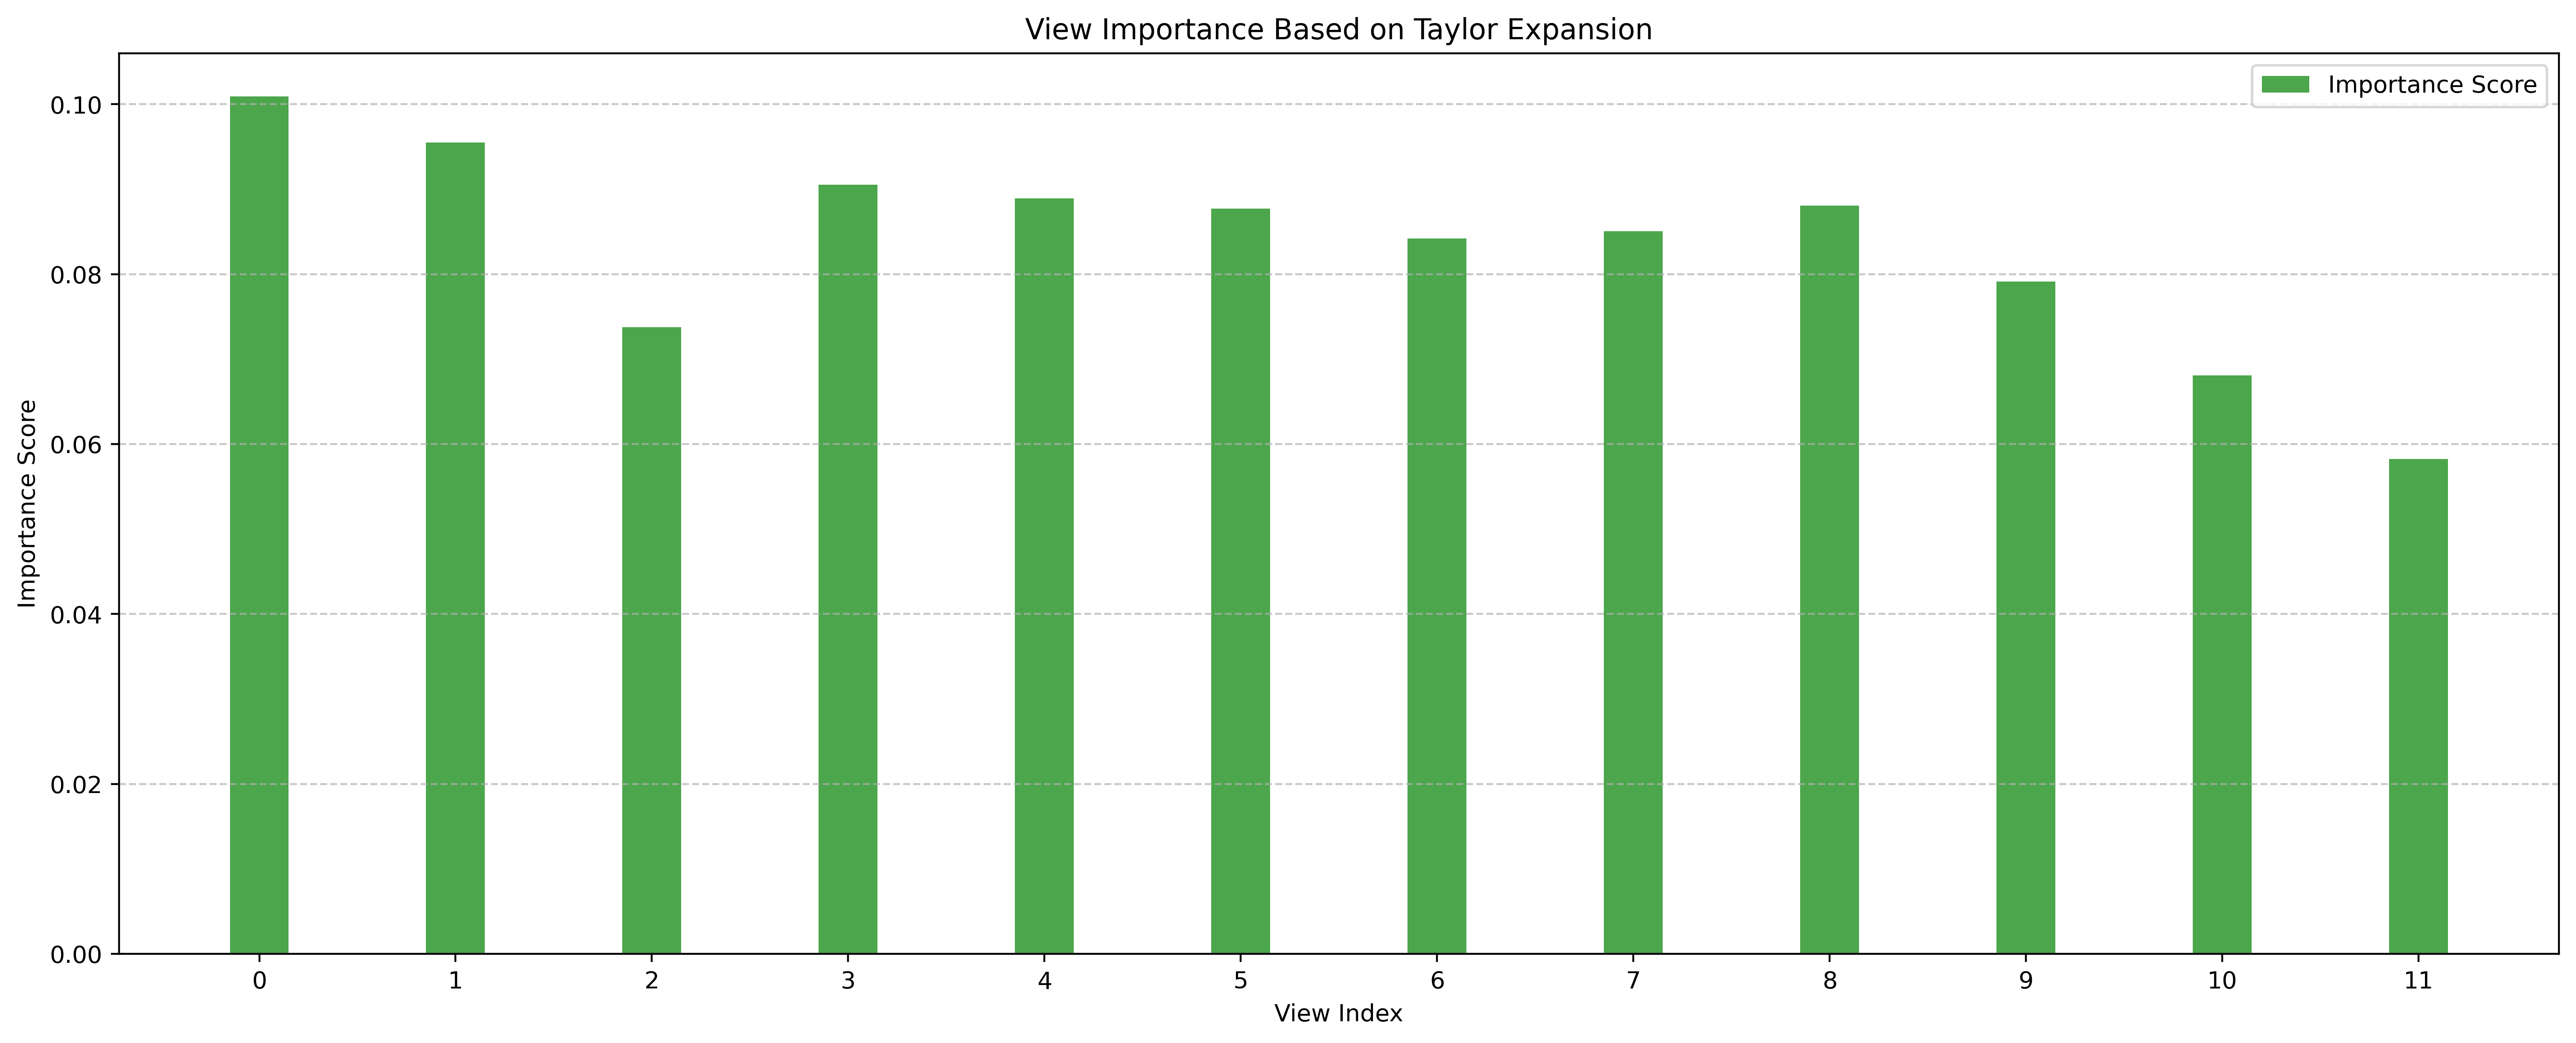

In [36]:
# Visualize the importance scores
import matplotlib.pyplot as plt
plt.style.use('default')
plt.figure(figsize=(15, 6), dpi=400)
plt.bar(range(num_views), view_importance.cpu().numpy(), color='green', alpha=0.7, label='Importance Score', width=0.3)
plt.xlabel('View Index')
plt.legend()
plt.tight_layout()
plt.ylabel('Importance Score')
plt.title('View Importance Based on Taylor Expansion')
plt.xticks(range(num_views))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## Load and Display Sample Views

Let's visualize some of the most and least important views to understand what the model finds useful.

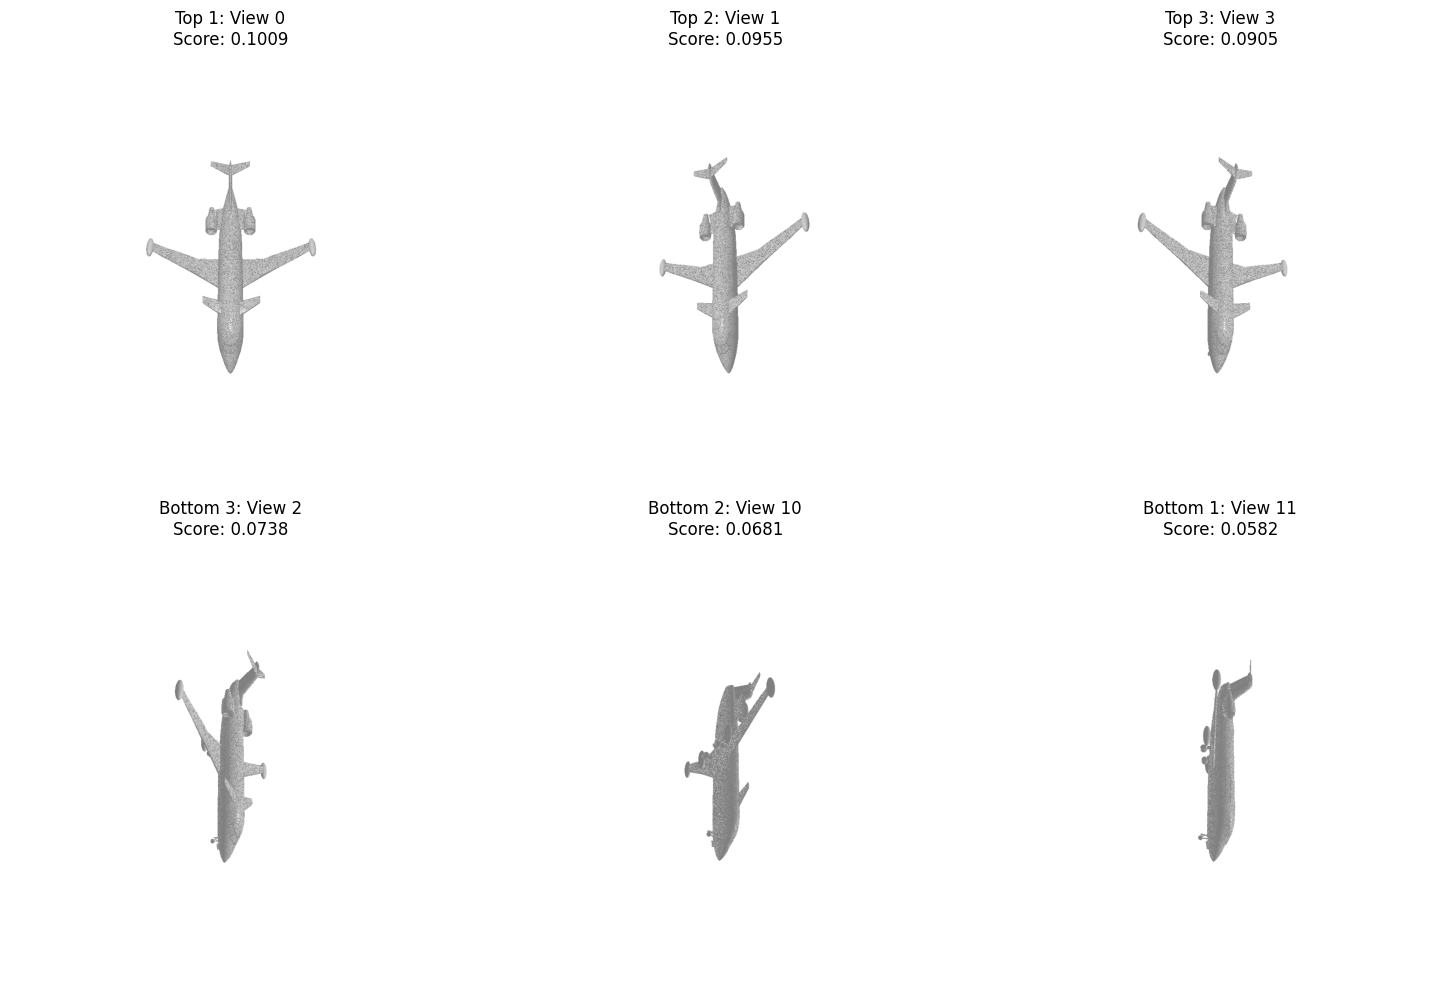

In [38]:
from PIL import Image
import torchvision.transforms as transforms

# Get the first sample from the dataset
for target, data, paths in test_loader:
    sample_paths = paths
    break

# Display most important views versus least important views
plt.figure(figsize=(15, 10))

# Get top 3 and bottom 3 views
top_views = sorted_paths[:3]
bottom_views = sorted_paths[-3:]

# Display top views
for i, idx in enumerate(top_views):
    plt.subplot(2, 3, i+1)
    img_path = sample_paths[idx.item()][0]  # Get the first sample's path for this view
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"Top {i+1}: View {idx.item()}\nScore: {view_importance[idx].item():.4f}")
    plt.axis('off')

# Display bottom views
for i, idx in enumerate(bottom_views):
    plt.subplot(2, 3, i+4)
    img_path = sample_paths[idx.item()][0]  # Get the first sample's path for this view
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"Bottom {len(bottom_views)-i}: View {idx.item()}\nScore: {view_importance[idx].item():.4f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [16]:
# Save the view importance scores
import pickle

result = {
    'view_importance': view_importance.cpu().numpy(),
    'sorted_views': sorted_paths.cpu().numpy()
}

with open('view_importance_results.pkl', 'wb') as f:
    pickle.dump(result, f)

print("View importance results saved to 'view_importance_results.pkl'")

View importance results saved to 'view_importance_results.pkl'
